In [ ]:
#Installing huggingface-transformers library
!pip install transformers

     |████████████████████████████████| 1.4MB 4.5MB/s 
     |████████████████████████████████| 890kB 30.0MB/s 
     |████████████████████████████████| 2.9MB 36.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=cef956cdcfcbb96973aba0b309d4726431c524d4356351a4afa278f125a357d0
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Importing required libraries
from google.colab import files
from ipywidgets import interact
from textblob import TextBlob
from wordcloud import WordCloud
from transformers import *
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import torch

In [ ]:
#Loading all files through a zip file
files.upload()

Saving project_data.zip to project_data.zip


{'project_data.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00Z\xb7VQ\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00mention/PK\x03\x04\x14\x00\x00\x00\x08\x00Z\xb7VQ\xb6D\xc7\x19\x92\x00\x00\x00>\x01\x00\x00\x1c\x00\x00\x00mention/airspace_opacity.txte\x8fQ\x0e\x83@\x08D\xffM\xbc\xc3^\xa0\x87\xa2,\xad\xc4\x157\x80i\xbc}Y\x1b\xb5\xb5\x7f\xcc\x9ba\x08s\x05\xe4\xbe\xcb\x84J`\x94\x93+\x88\x95\x05Ip\xed;\x96\x9dg\x12c\x0f\x04\xac\x16K\x942[\xb36r\xfbG\xe9\x82X\x1e\\\xa2\xdd\xbfg\x9e\xa5)\'5gg(i\x02\x1dY\x9e\x17Z\xc1C]\xb3eiA%g\\\n\xe8\x99:\xd1Q\xb7\xa3\xcf\xc9\n\x1a\x0f\x0e\xeb\x14-\x86\xa0\xbae*)\xdfu\x0e\xa3\xb5\xfb\xc08\x92l\xce\x0b\xca/hK}\xf7\x06PK\x03\x04\x14\x00\x00\x00\x08\x00Z\xb7VQ\xb7\xbc\xeeW\x16\x00\x00\x00\x14\x00\x00\x00\x17\x00\x00\x00mention/atelectasis.txtK,I\xcdIM.I\xe4\xe5J\xce\xcf\xc9I,(N\xe5\xe5\x02\x00PK\x03\x04\x14\x00\x00\x00\x08\x00Z\xb7VQ\x87\xd4\xe8\xa1R\x00\x00\x00\x8b\x00\x00\x00\x18\x00\x00\x00mention/cardiomegaly.txtU\x8dQ\n\xc0 \x0cC\xff\x05\xef\xe

In [ ]:
!unzip project_data.zip

Archive:  project_data.zip
   creating: mention/
  inflating: mention/airspace_opacity.txt  
  inflating: mention/atelectasis.txt  
  inflating: mention/cardiomegaly.txt  
  inflating: mention/consolidation.txt  
  inflating: mention/edema.txt       
  inflating: mention/enlarged_cardiomediastinum.txt  
  inflating: mention/fracture.txt    
  inflating: mention/lung_lesion.txt  
  inflating: mention/no_finding.txt  
  inflating: mention/pleural_effusion.txt  
  inflating: mention/pleural_other.txt  
  inflating: mention/pneumonia.txt   
  inflating: mention/pneumothorax.txt  
  inflating: mention/support_devices.txt  
   creating: unmention/
  inflating: unmention/airspace_opacity.txt  
  inflating: unmention/lung_lesion.txt  
  inflating: unmention/pleural_effusion.txt  
  inflating: CheXpert_report.csv     
  inflating: mentions.pkl            


In [ ]:
#Function to load all medical text files to a dict
def get_dict(path):
    label_to_mention = {}
    mention_files = os.listdir(path)
    for f in mention_files:
        with open(os.path.join(path, f)) as mention_file:
            condition = os.path.basename(f)[:-4]
            condition = condition.replace("_", " ").title()
            if condition not in label_to_mention:
                label_to_mention[condition] = []
            for line in mention_file:
                label_to_mention[condition].append(line.split("\n")[0])
    return label_to_mention

mentions = get_dict("mention")
mentions_pk = "mentions.pkl"
#serialization
pickle.dump(mentions, open(mentions_pk, "wb"))
#deserialization
mentions = pickle.load(open(mentions_pk, "rb"))

mentions.keys()

dict_keys(['Fracture', 'Pleural Effusion', 'Cardiomegaly', 'Pneumonia', 'Enlarged Cardiomediastinum', 'Atelectasis', 'Consolidation', 'Edema', 'Support Devices', 'Lung Lesion', 'No Finding', 'Airspace Opacity', 'Pneumothorax', 'Pleural Other'])

In [ ]:
#Reading the csv file (dataset)
df = pd.read_csv('CheXpert_report.csv')

In [ ]:
#Understanding the dataset
df.head()

,SimpleTestReportID,Report Impression,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Report Impression Parsed,Report Impression DG Paths
0,1.0,"\r\n \r\n1.mild pulmonary edema, and cardiomeg...",NaN,NaN,1.0,NaN,NaN,1.0,-1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,['(S1 (S (S (S (LST (LS 1.)) (NP (JJ mild) (JJ...,['/data3/CXR-CHEST/dgs/GL66832b_GL6dd686/0.pkl...
1,2.0,\r\n \r\n1.unremarkable cardiomediastinal silh...,NaN,0.0,NaN,NaN,1.0,NaN,0.0,-1.0,NaN,0.0,0.0,NaN,1.0,NaN,['(S1 (S (S (NP (LST (LS 1.)) (NN unremarkable...,['/data3/CXR-CHEST/dgs/GL6f51db_GL6f51dd/0.pkl...
2,3.0,\r\n1. lines and tubes are unchanged in positi...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (NNS lines))...,['/data3/CXR-CHEST/dgs/GL666dde_GL6b021a/0.pkl...
3,4.0,\r\n1. postoperative portable film with a righ...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,['(S1 (S (S (LST (LS 1.)) (NP (NP (JJ postoper...,['/data3/CXR-CHEST/dgs/GL6a8d08_GL6d5d21/0.pkl...
4,6.0,\r\n \r\n1.single frontal view of the chest de...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,1.0,['(S1 (S (S (NP (NP (LST (LS 1.)) (JJ single) ...,['/data3/CXR-CHEST/dgs/GL675b56_GL6f4eb9/0.pkl...


In [ ]:
print("No. of columns in the dataset: ", df.shape[1])
print("No. of rows in the dataset: ", df.shape[0])

No. of columns in the dataset:  18
No. of rows in the dataset:  1000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SimpleTestReportID          1000 non-null   float64
 1   Report Impression           1000 non-null   object 
 2   No Finding                  119 non-null    float64
 3   Enlarged Cardiomediastinum  212 non-null    float64
 4   Cardiomegaly                203 non-null    float64
 5   Lung Lesion                 48 non-null     float64
 6   Airspace Opacity            472 non-null    float64
 7   Edema                       354 non-null    float64
 8   Consolidation               367 non-null    float64
 9   Pneumonia                   126 non-null    float64
 10  Atelectasis                 301 non-null    float64
 11  Pneumothorax                384 non-null    float64
 12  Pleural Effusion            538 non-null    float64
 13  Pleural Other               42 non

In [ ]:
#Finding no. of missing value in each column of the dataset
data_na = df.isnull().sum()*100/len(df)
print("% of missing data in each feature:")
data_na.sort_values(ascending=False)

% of missing data in each feature:


Pleural Other                 95.8
Lung Lesion                   95.2
Fracture                      92.0
No Finding                    88.1
Pneumonia                     87.4
Cardiomegaly                  79.7
Enlarged Cardiomediastinum    78.8
Atelectasis                   69.9
Edema                         64.6
Consolidation                 63.3
Pneumothorax                  61.6
Support Devices               55.3
Airspace Opacity              52.8
Pleural Effusion              46.2
Report Impression              0.0
Report Impression DG Paths     0.0
Report Impression Parsed       0.0
SimpleTestReportID             0.0
dtype: float64

In [ ]:
#Explicitly writing all labels from the dataset 
CATEGORIES = ["Cardiomegaly", "Lung Lesion", "Airspace Opacity", "Edema", "Consolidation", "Pneumonia", 
              "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture"]

In [ ]:
#Preprocessing
df = df[['Report Impression'] + CATEGORIES]
df = df.replace(1, True).fillna(False).replace(0, False).replace(-1, False)

In [ ]:
print("No. of columns in the dataset: ", df.shape[1])
print("No. of rows in the dataset: ", df.shape[0])

No. of columns in the dataset:  12
No. of rows in the dataset:  1000


In [ ]:
df.head()

,Report Impression,Cardiomegaly,Lung Lesion,Airspace Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture
0,"\r\n \r\n1.mild pulmonary edema, and cardiomeg...",True,False,False,True,False,False,True,False,True,False,False
1,\r\n \r\n1.unremarkable cardiomediastinal silh...,False,False,True,False,False,False,False,False,False,False,True
2,\r\n1. lines and tubes are unchanged in positi...,False,False,True,False,False,False,False,False,False,False,False
3,\r\n1. postoperative portable film with a righ...,False,False,True,True,False,False,True,True,False,False,False
4,\r\n \r\n1.single frontal view of the chest de...,False,False,True,False,False,False,False,False,True,False,False


In [ ]:
#EDA
@interact(i=(0,len(df)-1))
def print_RI(i):
  print(f'\nReport Impression {i}:')
  print(df.loc[i, 'Report Impression'])

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

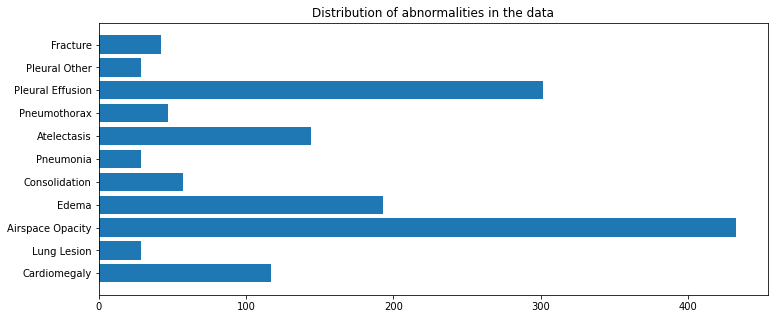

In [ ]:
#Bar chart on the distribution of abnormalities from the dataset
plt.figure(figsize=(12,5))
plt.barh(y=CATEGORIES, width=df[CATEGORIES].sum(axis=0))
plt.title('Distribution of abnormalities in the data')
plt.show()

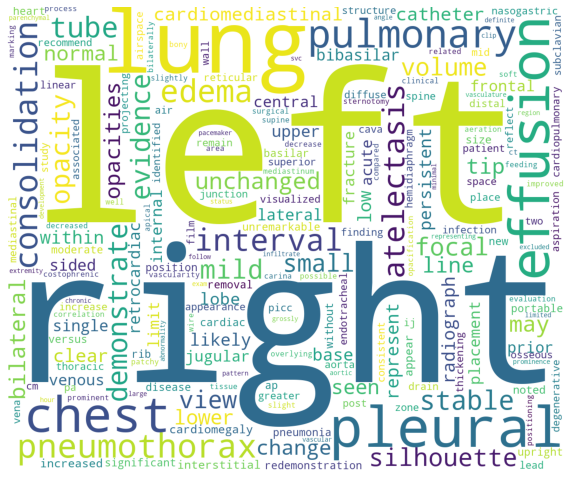

In [ ]:
#WordCloud plot on report impressions
plt.figure(figsize=(10,10))
words=' '.join(df['Report Impression'].apply(lambda x:x if x is not np.nan else ''))

wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

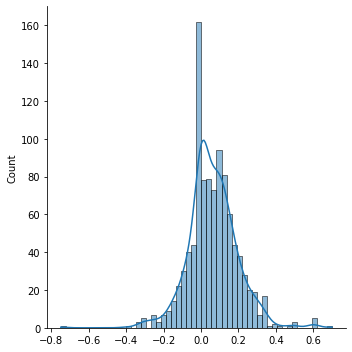

In [ ]:
#Distribution plot on sentiment polarity of the report impressions
polarity=[]
for i in range(0,len(df)):
  polarity.append(TextBlob(df['Report Impression'][i]).sentiment.polarity)
sns.displot(data=polarity, kde=True)

In [ ]:
#Function to get related keywords for each label in the dataset
def get_mention_keywords(observation):
    if observation in mentions:
        return mentions[observation]
    else:
        return []

In [ ]:
#Function to extract labels from the medical text
def get_labels(sentence_l):
    observation = {}
    for cat in CATEGORIES:
        observation[cat] = False
    for s in sentence_l:
        s = s.lower()
        for cat in CATEGORIES:
            for phrase in get_mention_keywords(cat):
                phrase = phrase.lower()
                if phrase in s:
                    observation[cat] = True
    return observation

In [ ]:
@interact(i=(0,len(df)-1))
def print_labels(i):
  print(f'\nReport Impression {i}:')
  sentence = df.loc[i, 'Report Impression']
  print(sentence)
  print()
  retrieved_labels = get_labels([sentence])
  print("Retrieved labels: ")
  for key, value in sorted(retrieved_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

In [ ]:
res = pd.DataFrame()
for i in range(0, len(df)):
  sentence = df.loc[i, 'Report Impression']
  retrieved_labels = get_labels([sentence])
  for cat in CATEGORIES:
    res.loc[i, cat] = retrieved_labels[cat]
res = res.astype(bool) 

In [ ]:
#Function to calculate F1 score for each label in the dataset
def calculate_f1(df, pred_frame):
    results = pd.DataFrame()
    for cat in CATEGORIES:
        gt = df[cat]
        pred = pred_frame[cat]
        f1 = metrics.f1_score(gt, pred)
        results = results.append({ "Label": cat, "F1": round(f1, 3)}, ignore_index=True)
    results = results.append({ "Label": "Average", "F1": round(results["F1"].mean(), 3)}, ignore_index=True)
    return results[["Label", "F1"]]

In [ ]:
#F1 scores of all labels in the dataset (not considering negative words)
f1_df = df.drop(['Report Impression'], axis=1)
calculate_f1(f1_df, res)

,Label,F1
0,Cardiomegaly,0.718
1,Lung Lesion,0.641
2,Airspace Opacity,0.923
3,Edema,0.708
4,Consolidation,0.270
5,Pneumonia,0.369
6,Atelectasis,0.646
7,Pneumothorax,0.218
8,Pleural Effusion,0.722
9,Pleural Other,0.667


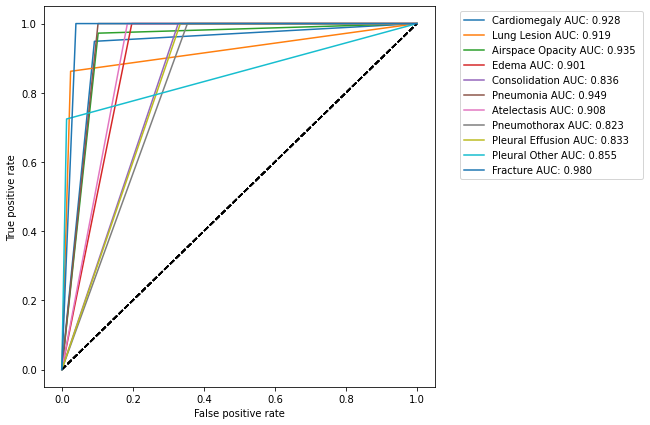

In [ ]:
#ROC curve of all labels in the data (not considering negative words)
gt = f1_df[CATEGORIES].values
pred = res[CATEGORIES].values
for i in range(len(CATEGORIES)):
  auc_roc = metrics.roc_auc_score(gt[:, i], pred[:, i])
  label = CATEGORIES[i] + " AUC: %.3f " % auc_roc
  xlabel = "False positive rate"
  ylabel = "True positive rate"
  a, b, _ = metrics.roc_curve(gt[:, i], pred[:, i])
  plt.figure(1, figsize=(7, 7))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(a, b, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
             fancybox=True, ncol=1)

In [ ]:
#Function to extract labels from sentence while assessing negative words in the medical text 
def get_labels_neg_mentions(sentence_l):
    negative_word_l = ["no", "not", "doesn't", "does not", "have not", "can not", "can't", "n't"]
    observation_n = {}
    for cat in CATEGORIES:
        observation_n[cat] = False
    for s in sentence_l:
        s = s.lower()
        negative_flag = False
        for neg in negative_word_l:
            if neg in s:
                negative_flag = True
                break
        if negative_flag != True:
            for cat in CATEGORIES:
                for phrase in get_mention_keywords(cat):
                        phrase = phrase.lower()
                        if phrase in s:
                            observation_n[cat] = True
    return observation_n

In [ ]:
@interact(i=(0,len(df)-1))
def print_labels(i):
  print(f'\nReport Impression {i}:')
  sentence = df.loc[i, 'Report Impression']
  print(sentence)
  print()
  retrieved_labels = get_labels_neg_mentions([sentence])
  print("Retrieved labels: ")
  for key, value in sorted(retrieved_labels.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))

interactive(children=(IntSlider(value=499, description='i', max=999), Output()), _dom_classes=('widget-interac…

In [ ]:
neg = pd.DataFrame()
for i in range(0, len(df)):
  sentence = df.loc[i, 'Report Impression']
  retrieved_labels = get_labels_neg_mentions([sentence])
  for cat in CATEGORIES:
    neg.loc[i, cat] = retrieved_labels[cat]
neg = neg.astype(bool)

In [ ]:
#F1 scores of all labels in the data (considering negative words)
calculate_f1(f1_df, neg)

,Label,F1
0,Cardiomegaly,0.500
1,Lung Lesion,0.125
2,Airspace Opacity,0.488
3,Edema,0.581
4,Consolidation,0.392
5,Pneumonia,0.364
6,Atelectasis,0.325
7,Pneumothorax,0.471
8,Pleural Effusion,0.561
9,Pleural Other,0.256


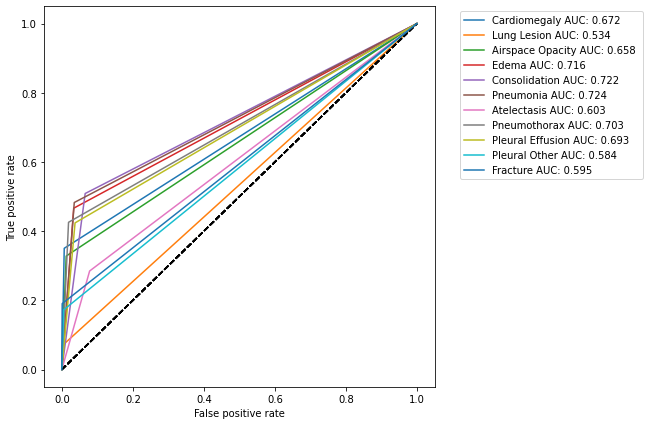

In [ ]:
#ROC curve of all labels in the data (considering negative words)
gt_n = f1_df[CATEGORIES].values
pred_n = neg[CATEGORIES].values
for i in range(len(CATEGORIES)):
  auc_roc = metrics.roc_auc_score(gt_n[:, i], pred_n[:, i])
  label = CATEGORIES[i] + " AUC: %.3f " % auc_roc
  xlabel = "False positive rate"
  ylabel = "True positive rate"
  a, b, _ = metrics.roc_curve(gt_n[:, i], pred_n[:, i])
  plt.figure(1, figsize=(7, 7))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(a, b, label=label)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
             fancybox=True, ncol=1)

In [ ]:
#Loading pre-trained BERT tokenizers and models
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
#Sample clinical notes
passage = "Abnormal echocardiogram findings and followup. Shortness of breath, congestive heart failure, \
           and valvular insufficiency. The patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. The patient is an 86-year-old female admitted for evaluation of abdominal pain \
           and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. \
           During the hospitalization, the patient complains of shortness of breath, which is worsening. \
           The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large \
           pleural effusion. This consultation is for further evaluation in this regard. As per the patient, \
           she is an 86-year-old female, has limited activity level. She has been having shortness of breath \
           for many years. She also was told that she has a heart murmur, which was not followed through \
           on a regular basis."

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "What does her echocardiogram show?"
q5 = "What other symptoms does the patient have?"

questions = [q1, q2, q3, q4, q5]

In [ ]:
#Function to display input text tokens and it's ID
def disp_tokens(passage, question):
  #tokenizing passage and text
  input_ids = tokenizer.encode(question, passage)

  #converting input tokens to string for displaying
  tokens = tokenizer.convert_ids_to_tokens(input_ids)
  for token, id in zip(tokens, input_ids): 
    if id == tokenizer.sep_token_id:
        print('')
    print('{:<12} {:>6,}'.format(token, id))  #printing token and it's ID as 2 columns
    if id == tokenizer.sep_token_id:
        print('')    

In [ ]:
disp_tokens(passage, questions[0])

[CLS]           101
how           2,129
old           2,214
is            2,003
the           1,996
patient       5,776
?             1,029

[SEP]           102

abnormal     19,470
echo          9,052
##card       11,522
##io          3,695
##gram       13,113
findings      9,556
and           1,998
follow        3,582
##up          6,279
.             1,012
short         2,460
##ness        2,791
of            1,997
breath        3,052
,             1,010
cong         26,478
##est         4,355
##ive         3,512
heart         2,540
failure       4,945
,             1,010
and           1,998
val          11,748
##vu         19,722
##lar         8,017
ins          16,021
##uf         16,093
##fi          8,873
##ciency     29,125
.             1,012
the           1,996
patient       5,776
complain     17,612
##s           2,015
of            1,997
short         2,460
##ness        2,791
of            1,997
breath        3,052
,             1,010
which         2,029
is            2,00

In [ ]:
#Function to perform question answering task
def QA_system(question, text):
    #encoding and tokenizing passage and text into single vector
    input_ids = tokenizer.encode(question, text)
    
    #searching input_ids for first instance of the [SEP] token
    sep_index = input_ids.index(tokenizer.sep_token_id)

    #number of segment A tokens including the [SEP] token
    num_seg_a = sep_index + 1

    #remaining number of segments
    num_seg_b = len(input_ids) - num_seg_a
    
    #constructing the list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    #segment_id for every input token
    assert len(segment_ids) == len(input_ids)

    #evaluating the model
    output = model(torch.tensor([input_ids]), # tokens representing input text
                                    token_type_ids=torch.tensor([segment_ids])) # segment IDs to differentiate question from passage
    start_scores = output.start_logits
    end_scores = output.end_logits
    
    #finding the tokens with the highest 'start' and 'end' scores
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    #converting input tokens to strings for displaying
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    #selecting first token to determine the answer
    answer = tokens[answer_start]

    #selecting remaining answer tokens and joining them with whitespaces
    for i in range(answer_start + 1, answer_end + 1):
        if tokens[i][0:2] == '##': # recombining sub-word token with previous token 
            answer += tokens[i][2:]
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [ ]:
for i, q in enumerate(questions):
    print("Question {}: {}".format(i+1, q))
    print()
    QA_system(q, passage)
    print()

Question 1: How old is the patient?

Answer: "86"

Question 2: Does the patient have any complaints?

Answer: "the patient complains of shortness of breath"

Question 3: What is the reason for this consultation?

Answer: "further evaluation"

Question 4: What does her echocardiogram show?

Answer: "severe mitral regurgitation and also large pleural effusion"

Question 5: What other symptoms does the patient have?

Answer: "colitis and also diverticulitis"



In [ ]:
#Second sample clinical notes
passage2 = r"""He is a 29-year-old white male who is a patient of Dr. XYZ and he comes in today complaining \
              that he was stung by a Yellow Jacket Wasp yesterday and now has a lot of swelling in his right \
              hand and right arm. He says that he has been stung by wasps before and had similar reactions. He \
              just said that he wanted to catch it early before he has too bad of a severe reaction like he has \
              had in the past. He has had a lot of swelling, but no anaphylaxis-type reactions in the past; no \
              shortness of breath or difficultly with his throat feeling like it is going to close up or anything \
              like that in the past; no racing heart beat or anxiety feeling, just a lot of localized swelling where the sting occurs."""

q1 = "How old is the patient?"
q2 = "Does the patient have any complaints?"
q3 = "What is the reason for this consultation?"
q4 = "Has the patient experienced similar symptoms before?"
q5 = "What other symptoms does the patient have?"

quesn = [q1, q2, q3, q4, q5]

In [ ]:
for i, q in enumerate(quesn):
    print("Question {}: {}".format(i+1, q))
    print()
    QA_system(q, passage2)
    print()

Question 1: How old is the patient?

Answer: "29"

Question 2: Does the patient have any complaints?

Answer: "he has had a lot of swelling , but no anaphylaxis - type reactions in the past ; no shortness of breath or difficultly with his throat feeling like it is going to close up or anything like that in the past"

Question 3: What is the reason for this consultation?

Answer: "he wanted to catch it early before he has too bad of a severe reaction"

Question 4: Has the patient experienced similar symptoms before?

Answer: "he has been stung by wasps before"

Question 5: What other symptoms does the patient have?

Answer: "no racing heart beat or anxiety feeling"

